In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
dataset, info = tfds.load("rock_paper_scissors", as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2520 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteEMKXOO/rock_paper_scissors-train.tfrec…

Generating test examples...:   0%|          | 0/372 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteEMKXOO/rock_paper_scissors-test.tfreco…

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


In [3]:
info

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    full_name='rock_paper_scissors/3.0.0',
    description="""
    Images of hands playing rock, paper, scissor game.
    """,
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    data_dir=PosixGPath('/tmp/tmpswc9fikftfds'),
    file_format=tfrecord,
    download_size=219.53 MiB,
    dataset_size=219.23 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=372, num_shards=1>,
        'train': <SplitInfo num_examples=2520, num_shards=2>,
    },
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
)

In [4]:
class_names = info.features['label'].names
class_names

['rock', 'paper', 'scissors']

In [5]:
n_classes = info.features['label'].num_classes
n_classes

3

In [6]:
train_set_size = info.splits['train'].num_examples
test_set_size = info.splits['test'].num_examples

train_set_size, test_set_size

(2520, 372)

# Training, Validation, Test Set 분리

In [7]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load('rock_paper_scissors', as_supervised=True, split=['test[0%:]', 'train[:15%]', 'train[15%:]'])

# 데이터 전처리
  

In [8]:
import keras

In [9]:
def preprocess(image, label):
  resized_image = tf.image.resize(image, [224, 224])
  final_image = keras.applications.vgg16.preprocess_input(resized_image)
  return final_image, label


batch_size = 50

train_set = train_set_raw.shuffle(10).repeat()
train_set = train_set_raw.map(preprocess).batch(batch_size).prefetch(1)

valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)

test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

# VGG16 합성곱 기반 층 만들기

In [10]:
conv_base = keras.applications.vgg16.VGG16(
    weights='imagenet',
    include_top=False)

conv_base.trainable = True

for layer in conv_base.layers[:-4]:
  layer.trainable = False

58889256/58889256 [==============================] - 1s 0us/step


In [11]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

# 데이터 증식을 사용하지 않는 빠른 특성 추출

## VGG16 특성과 해당 레이블 추출하기

In [12]:
import numpy as np


def get_features_and_labels(dataset):
  all_features = []
  all_labels = []

  for images, labels in dataset:
    preprocessed_images = keras.applications.vgg16.preprocess_input(images)
    features = conv_base.predict(preprocessed_images)
    all_features.append(features)
    all_labels.append(labels)

  return np.concatenate(all_features), np.concatenate(all_labels)  # [[1,0], [2,1]] >> [1, 0, 1, 2]


In [13]:
val_features, val_labels = get_features_and_labels(valid_set)


1/1 [==============================] - 6s 6s/step


In [14]:
train_features, train_labels = get_features_and_labels(train_set)

2/2 [==============================] - 3s 3s/step


In [15]:
train_features.shape

(2142, 7, 7, 512)

## 밀집 연결 분류기 정의하고 훈련하기

In [16]:
from keras import layers

In [17]:
inputs = keras.Input(shape=(7, 7, 512))
x = layers.Flatten()(inputs)  #  Dense 층에 특성을 주입하기 전 Flatten 층을 사용
x = layers.Dense(30)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation='softmax')(x)

model = keras.Model(inputs, outputs)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              metrics=['accuracy'])


checkpoint = [
    keras.callbacks.ModelCheckpoint(
        filepath='rock_paper_scissors_no_augmentation',
        save_best_only=True,
        monitor='val_loss'
    )
]
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

history = model.fit(
    train_features, train_labels,
    epochs=50,
    steps_per_epoch = 0.85 * train_set_size / batch_size,
    validation_data=(val_features, val_labels),
    callbacks=[checkpoint, early_stopping ]
)

Epoch 1/50
42/42 [==============================] - 4s 26ms/step - loss: 7.6991 - accuracy: 0.5215 - val_loss: 0.8154 - val_accuracy: 0.8889
Epoch 2/50
42/42 [==============================] - 1s 18ms/step - loss: 2.2494 - accuracy: 0.7983 - val_loss: 0.2032 - val_accuracy: 0.9524
Epoch 3/50
42/42 [==============================] - 1s 19ms/step - loss: 1.1426 - accuracy: 0.8744 - val_loss: 0.0158 - val_accuracy: 0.9921
Epoch 4/50
42/42 [==============================] - 1s 20ms/step - loss: 0.5450 - accuracy: 0.9239 - val_loss: 5.9123e-04 - val_accuracy: 1.0000
Epoch 5/50
42/42 [==============================] - 1s 27ms/step - loss: 0.3933 - accuracy: 0.9458 - val_loss: 1.3730e-05 - val_accuracy: 1.0000
Epoch 6/50
42/42 [==============================] - 1s 27ms/step - loss: 0.2788 - accuracy: 0.9533 - val_loss: 1.9450e-06 - val_accuracy: 1.0000
Epoch 7/50
42/42 [==============================] - 1s 20ms/step - loss: 0.1873 - accuracy: 0.9711 - val_loss: 3.0559e-07 - val_accuracy: 1.00

## 결과 그래프로 나타내기

In [18]:
import matplotlib.pyplot as plt

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

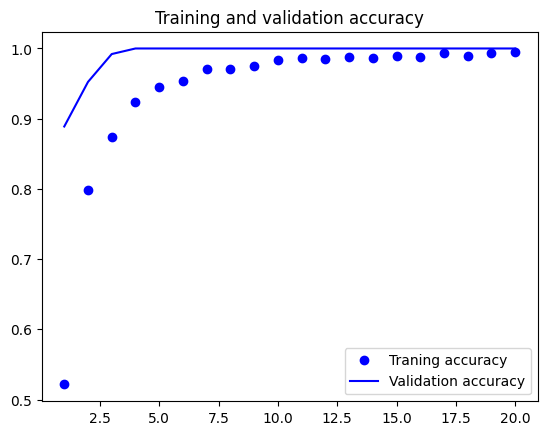

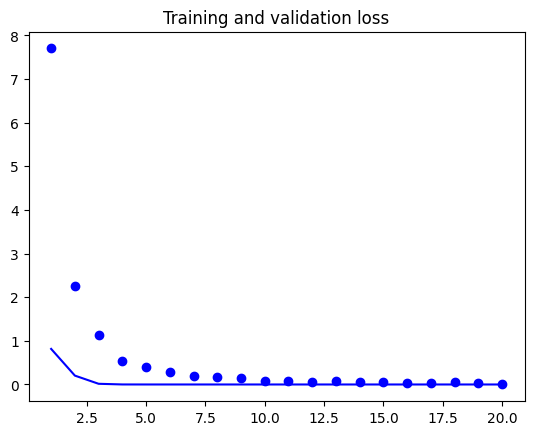

In [20]:
plt.plot(epochs, acc, 'bo', label='Traning accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.show()

## 테스트 세트에서 모델 평가하기

In [21]:
test_features, test_labels = get_features_and_labels(test_set)


1/1 [==============================] - 5s 5s/step


In [22]:
import time

test_model = keras.models.load_model(
    'rock_paper_scissors_no_augmentation'
)

start_time = time.time()
test_loss, test_acc = test_model.evaluate(test_features, test_labels)
end_time = time.time()
prediction_time = end_time - start_time
print(f'prediction time: {prediction_time}')

12/12 [==============================] - 0s 3ms/step - loss: 2.6750 - accuracy: 0.8038
prediction time: 0.2380537986755371
